In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb

In [2]:
df_x = pd.read_csv("data_X.csv")

In [3]:
df_y = pd.read_csv("data_Y.csv")
df_y

,date_time,quality
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400
...,...,...
29179,2018-05-03 19:05:00,438
29180,2018-05-03 20:05:00,452
29181,2018-05-03 21:05:00,455
29182,2018-05-03 22:05:00,455


In [4]:
df_x["date_time"]=pd.to_datetime(df_x["date_time"])
df_x["date_hour"] = df_x["date_time"].apply(lambda x: x.strftime("%d-%m-%Y-%H-%M"))
df_x["date"] = df_x["date_time"].apply(lambda x: x.strftime("%Y-%m-%d"))

In [5]:
df_y['date_time'] = pd.to_datetime(df_y["date_time"])
df_y["date_hour"] = df_y["date_time"].apply(lambda df_y: df_y.strftime("%d-%m-%Y-%H-%M"))

In [6]:
df_data = pd.merge(df_x,df_y,on='date_hour')

<AxesSubplot:>

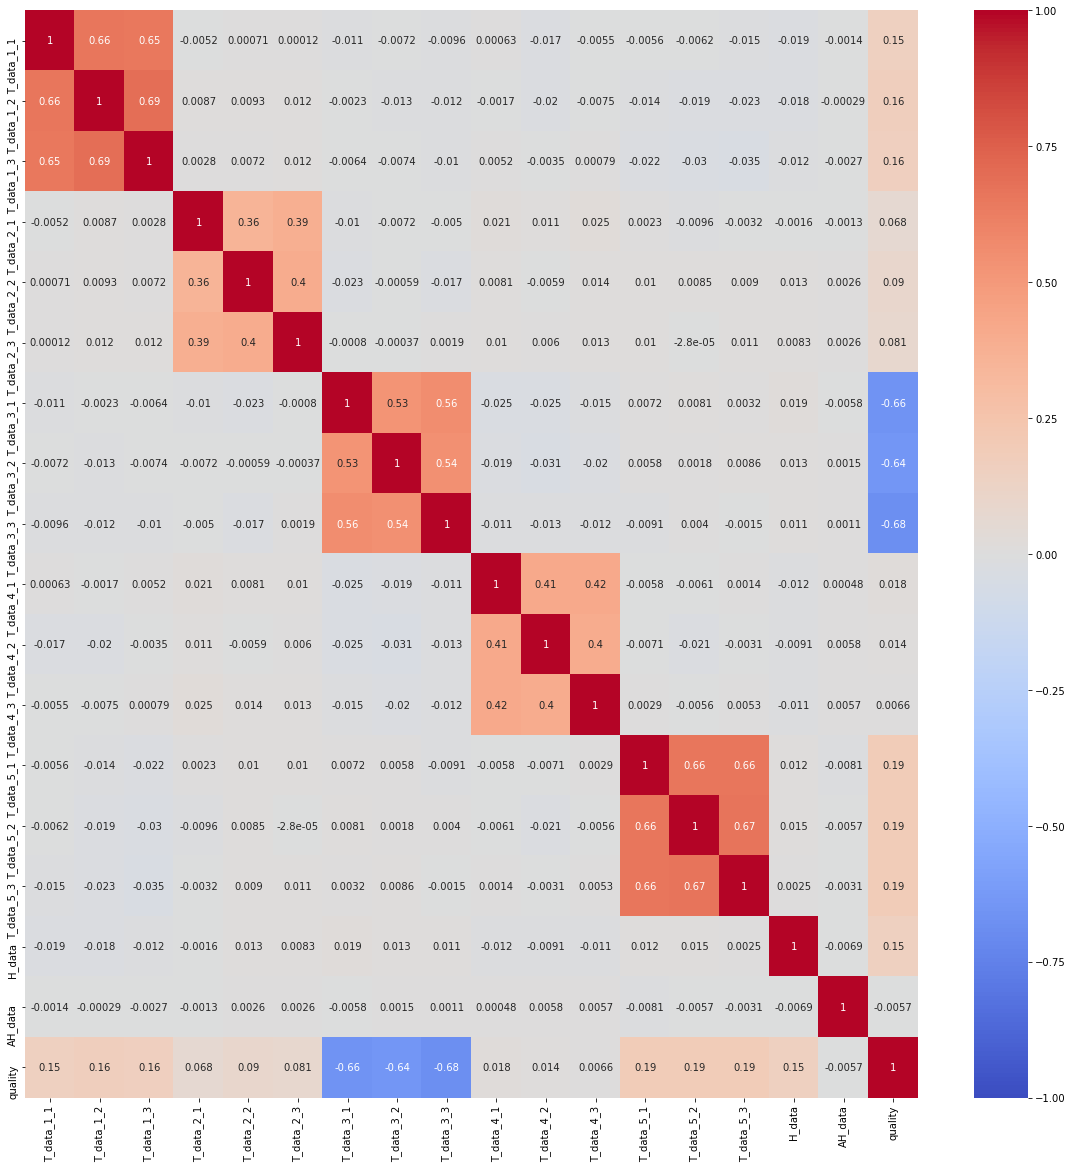

In [7]:
plt.figure(figsize=(20,20))
snb.heatmap(df_data.drop(['date_time_x','date_hour','date','date_time_y'],axis=1).corr(),vmin=-1, cmap='coolwarm', annot=True)

In [8]:
submission = pd.read_csv('sample_submission.csv')

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [10]:
x = df_data.drop(['date_time_x','date_hour','date','quality','date_time_y'],axis=1)
y = df_data['quality']

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [12]:
dtree = DecisionTreeRegressor()
dtree.fit(x_train,y_train)

DecisionTreeRegressor()

In [13]:
y_pred = dtree.predict(x_test)

In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test,y_pred)
print(mae)

15.345120614035087


In [15]:
import xgboost as xgb

In [16]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
dt_model = DecisionTreeRegressor(random_state=0)
X_val = df_data.drop(['date_time_x','date_hour','date','quality','date_time_y'],axis=1)
y_val = df_data['quality']

In [17]:
from sklearn.model_selection import cross_val_score
xgb_cv =cross_val_score(xgb_model,X_val,y_val,cv=10,scoring=('neg_mean_absolute_error'))

In [18]:
print("Average XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.mean())))
print("Best XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.max())))

Average XGB Cross Validation MAE: 10.454783170015862
Best XGB Cross Validation MAE: 10.05019754641182


In [19]:
cv_dt = cross_val_score(dt_model,X_val,y_val,cv=5,scoring=('neg_mean_absolute_error'))

In [20]:
print("Average Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.mean())))
print("Best Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.max())))

Average Decision Tree Cross Validation MAE: 15.793784697909851
Best Decision Tree Cross Validation MAE: 15.420935412026726


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [250, 500,750],
    'max_depth': [3,5,10],
    'min_child_weight':range(1,6,2)
}

In [22]:
gsearch1 = GridSearchCV(estimator = xgb_model,param_grid = param_grid)
gsearch1.fit(x_train,y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    eta=0.1, gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=7, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.7,
                                    tree_method=None, validate_parameters=None,
 

In [23]:
gsearch1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
cv_bestparam = cross_val_score(gsearch1.best_estimator_,X_val,y_val,cv=5,scoring=('neg_mean_absolute_error'))

In [25]:
print("Best Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_bestparam.max())))
print("Average Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_bestparam.mean())))

Best Decision Tree Cross Validation MAE: 10.009645162389278
Average Decision Tree Cross Validation MAE: 10.260710042580651


In [26]:
df_upd = df_x[(df_x['date_hour']>"01-01-2015-00-05")].reset_index()
df_upd2 = df_upd.drop(['date_time','date_hour','date','AH_data','index'],axis=1)

In [27]:
df_upd["minute"] = df_upd["date_time"].dt.minute

In [28]:
df_upd.drop('index',axis=1,inplace=True)

In [29]:
df_upd

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,...,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,date_hour,date,minute
0,2015-01-01 00:06:00,213,212,211,341,349,346,480,473,482,...,350,354,244,241,242,166.14,9.22,01-01-2015-00-06,2015-01-01,6
1,2015-01-01 00:07:00,213,212,211,340,348,345,482,473,482,...,350,354,244,241,242,164.38,9.22,01-01-2015-00-07,2015-01-01,7
2,2015-01-01 00:08:00,213,212,211,339,347,345,483,473,482,...,350,354,244,241,242,163.89,9.22,01-01-2015-00-08,2015-01-01,8
3,2015-01-01 00:09:00,213,212,211,338,347,345,484,473,483,...,350,354,245,241,242,162.82,9.22,01-01-2015-00-09,2015-01-01,9
4,2015-01-01 00:10:00,213,212,211,337,346,345,485,473,483,...,350,353,245,241,241,161.27,9.22,01-01-2015-00-10,2015-01-01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103830,2018-12-31 23:56:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,157.20,8.44,31-12-2018-23-56,2018-12-31,56
2103831,2018-12-31 23:57:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,160.40,8.44,31-12-2018-23-57,2018-12-31,57
2103832,2018-12-31 23:58:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,160.14,8.44,31-12-2018-23-58,2018-12-31,58
2103833,2018-12-31 23:59:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,162.96,8.44,31-12-2018-23-59,2018-12-31,59


In [30]:
df_np = df_upd.to_numpy()
df_np

array([[Timestamp('2015-01-01 00:06:00'), 213, 212, ...,
        '01-01-2015-00-06', '2015-01-01', 6],
       [Timestamp('2015-01-01 00:07:00'), 213, 212, ...,
        '01-01-2015-00-07', '2015-01-01', 7],
       [Timestamp('2015-01-01 00:08:00'), 213, 212, ...,
        '01-01-2015-00-08', '2015-01-01', 8],
       ...,
       [Timestamp('2018-12-31 23:58:00'), 271, 261, ...,
        '31-12-2018-23-58', '2018-12-31', 58],
       [Timestamp('2018-12-31 23:59:00'), 271, 261, ...,
        '31-12-2018-23-59', '2018-12-31', 59],
       [Timestamp('2019-01-01 00:00:00'), 271, 261, ...,
        '01-01-2019-00-00', '2019-01-01', 0]], dtype=object)

In [31]:
df_np2 = df_upd2.to_numpy()
df_np2[0]

array([213.  , 212.  , 211.  , 341.  , 349.  , 346.  , 480.  , 473.  ,
       482.  , 363.  , 350.  , 354.  , 244.  , 241.  , 242.  , 166.14])

In [32]:
df_upd

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,...,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,date_hour,date,minute
0,2015-01-01 00:06:00,213,212,211,341,349,346,480,473,482,...,350,354,244,241,242,166.14,9.22,01-01-2015-00-06,2015-01-01,6
1,2015-01-01 00:07:00,213,212,211,340,348,345,482,473,482,...,350,354,244,241,242,164.38,9.22,01-01-2015-00-07,2015-01-01,7
2,2015-01-01 00:08:00,213,212,211,339,347,345,483,473,482,...,350,354,244,241,242,163.89,9.22,01-01-2015-00-08,2015-01-01,8
3,2015-01-01 00:09:00,213,212,211,338,347,345,484,473,483,...,350,354,245,241,242,162.82,9.22,01-01-2015-00-09,2015-01-01,9
4,2015-01-01 00:10:00,213,212,211,337,346,345,485,473,483,...,350,353,245,241,241,161.27,9.22,01-01-2015-00-10,2015-01-01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103830,2018-12-31 23:56:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,157.20,8.44,31-12-2018-23-56,2018-12-31,56
2103831,2018-12-31 23:57:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,160.40,8.44,31-12-2018-23-57,2018-12-31,57
2103832,2018-12-31 23:58:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,160.14,8.44,31-12-2018-23-58,2018-12-31,58
2103833,2018-12-31 23:59:00,271,261,265,353,359,353,481,449,491,...,328,328,277,276,280,162.96,8.44,31-12-2018-23-59,2018-12-31,59


In [33]:
# data_club = df_upd.drop(['date_time_x','date_hour','date_time_y','quality'],axis=1).to_numpy()

In [34]:
# data_club[0] = np.append(data_club[0],df2_np[j])

In [35]:
# j=0
# k=0
# final_data = dict()
# temp = []
# upd_df = pd.DataFrame()
# for i,row in df_upd.iterrows():
#     if row['hour_minute']=="00-05":
#         j+=1
#         final_data.update({i:(np.append(temp,df2_np[k]))})
#         temp = []
#         k+=1
#     elif row['hour_minute']!="00-05" and len(temp)==0:
#         temp = np.append(data_club[j],df2_np[k])
#         k+=1
#     else:
#         temp = np.append(temp,df2_np[k])
#         k+=1

In [36]:
df_upd.reset_index(inplace=True)
df_upd.drop('index',axis=1,inplace=True)

In [37]:
# final_data = dict()
# j=0
# for i,row in df_upd.iterrows():
#     if row['hour_minute']==05":
#         final_data.update({j:df2_np[i]})
#         j+=1

In [38]:
df_np2[0]

array([213.  , 212.  , 211.  , 341.  , 349.  , 346.  , 480.  , 473.  ,
       482.  , 363.  , 350.  , 354.  , 244.  , 241.  , 242.  , 166.14])

In [39]:
from scipy.stats import mode
from datetime import datetime
start = datetime.now()
print("Start time:",start)
final_data = dict()
temp = []
ah_data = []
h_data = []
j=0
for i,row in df_upd.iterrows():
    ah_data.append(row['AH_data'])
#     h_data.append(row['H_data'])
    if row['minute']==5:
        temp = np.append(temp,df_np2[i])
        temp = np.append(temp,mode(ah_data)[0])
#         temp = np.append(temp,mode(h_data)[0])
        final_data.update({j:temp})
        temp = []
        ah_data = []
        h_data = []
        j+=1
    else:
        temp = np.append(temp,df_np2[i])
    
duration = datetime.now()-start
print("End time:",datetime.now())
print("Duration:",duration)

Start time: 2021-08-29 13:07:50.113539
End time: 2021-08-29 13:12:09.267040
Duration: 0:04:19.153501


In [40]:
upd_df  = pd.DataFrame(final_data.values())

In [41]:
upd_df.iloc[0]

0      213.00
1      212.00
2      211.00
3      341.00
4      349.00
        ...  
956    242.00
957    240.00
958    238.00
959    165.65
960      9.22
Name: 0, Length: 961, dtype: float64

In [42]:
# from datetime import datetime
# df_x['date'] = pd.to_datetime(df_x['date'],format='%Y-%m-%d')
# df_x[(df_x['date']>=pd.Timestamp(date(2015,1,3))) & (df_x['date']<=pd.Timestamp(date(2015,1,4)))]

In [43]:
# df_upd[(df_upd['date_hour']>'03-01-2015 00-05') & (df_upd['date_hour']<='03-01-2015 00-10')]

In [44]:
# from datetime import datetime
# df_upd[(df_upd['date_hour']>pd.Timestamp(datetime(2015,1,3,0,5))) & (df_upd['date_hour']<=pd.Timestamp(datetime(2015,1,3,1,5)))]

In [45]:
upd_df['date_time'] =  df_upd[df_upd['minute']==5]['date_time'].reset_index().drop('index',axis=1)

In [46]:
df_y['date_time'] = pd.to_datetime(df_y['date_time'])

In [47]:
dfCombdata = pd.merge(upd_df,df_y,on='date_time')

In [48]:
dfCombdata

,0,1,2,3,4,5,6,7,8,9,...,954,955,956,957,958,959,960,date_time,quality,date_hour
0,266.0,339.0,263.0,334.0,326.0,341.0,496.0,498.0,537.0,317.0,...,379.0,337.0,231.0,236.0,242.0,153.77,4.73,2015-01-04 00:05:00,392,04-01-2015-00-05
1,277.0,326.0,273.0,322.0,335.0,352.0,504.0,501.0,673.0,326.0,...,396.0,335.0,234.0,242.0,230.0,158.27,7.90,2015-01-04 01:05:00,384,04-01-2015-01-05
2,277.0,252.0,271.0,320.0,333.0,355.0,500.0,501.0,684.0,337.0,...,399.0,332.0,243.0,251.0,240.0,153.36,6.96,2015-01-04 02:05:00,393,04-01-2015-02-05
3,261.0,218.0,260.0,326.0,336.0,329.0,505.0,499.0,445.0,347.0,...,387.0,334.0,257.0,258.0,246.0,153.21,7.29,2015-01-04 03:05:00,399,04-01-2015-03-05
4,243.0,238.0,252.0,327.0,329.0,308.0,520.0,498.0,541.0,342.0,...,371.0,344.0,264.0,263.0,265.0,195.71,7.11,2015-01-04 04:05:00,400,04-01-2015-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179,256.0,250.0,262.0,381.0,388.0,365.0,455.0,327.0,465.0,357.0,...,350.0,349.0,234.0,254.0,252.0,157.47,7.79,2018-05-03 19:05:00,438,03-05-2018-19-05
29180,257.0,258.0,266.0,378.0,381.0,358.0,450.0,388.0,461.0,354.0,...,344.0,348.0,235.0,253.0,247.0,157.17,7.33,2018-05-03 20:05:00,452,03-05-2018-20-05
29181,259.0,255.0,260.0,372.0,367.0,362.0,431.0,460.0,453.0,359.0,...,360.0,345.0,256.0,257.0,247.0,155.00,7.87,2018-05-03 21:05:00,455,03-05-2018-21-05
29182,260.0,254.0,263.0,364.0,349.0,352.0,429.0,425.0,446.0,348.0,...,357.0,344.0,254.0,265.0,248.0,153.89,7.65,2018-05-03 22:05:00,455,03-05-2018-22-05


In [49]:
dfCombdata_x = dfCombdata.drop(['date_time','quality','date_hour'],axis=1)
dfCombdata_y = dfCombdata['quality']

In [50]:
dfCombdata_x

,0,1,2,3,4,5,6,7,8,9,...,951,952,953,954,955,956,957,958,959,960
0,266.0,339.0,263.0,334.0,326.0,341.0,496.0,498.0,537.0,317.0,...,501.0,670.0,326.0,379.0,337.0,231.0,236.0,242.0,153.77,4.73
1,277.0,326.0,273.0,322.0,335.0,352.0,504.0,501.0,673.0,326.0,...,501.0,687.0,337.0,396.0,335.0,234.0,242.0,230.0,158.27,7.90
2,277.0,252.0,271.0,320.0,333.0,355.0,500.0,501.0,684.0,337.0,...,499.0,443.0,347.0,399.0,332.0,243.0,251.0,240.0,153.36,6.96
3,261.0,218.0,260.0,326.0,336.0,329.0,505.0,499.0,445.0,347.0,...,498.0,540.0,342.0,387.0,334.0,257.0,258.0,246.0,153.21,7.29
4,243.0,238.0,252.0,327.0,329.0,308.0,520.0,498.0,541.0,342.0,...,501.0,524.0,343.0,371.0,344.0,264.0,263.0,265.0,195.71,7.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179,256.0,250.0,262.0,381.0,388.0,365.0,455.0,327.0,465.0,357.0,...,386.0,461.0,354.0,350.0,349.0,234.0,254.0,252.0,157.47,7.79
29180,257.0,258.0,266.0,378.0,381.0,358.0,450.0,388.0,461.0,354.0,...,461.0,453.0,360.0,344.0,348.0,235.0,253.0,247.0,157.17,7.33
29181,259.0,255.0,260.0,372.0,367.0,362.0,431.0,460.0,453.0,359.0,...,425.0,446.0,348.0,360.0,345.0,256.0,257.0,247.0,155.00,7.87
29182,260.0,254.0,263.0,364.0,349.0,352.0,429.0,425.0,446.0,348.0,...,468.0,441.0,347.0,357.0,344.0,254.0,265.0,248.0,153.89,7.65


In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [52]:
dfCombdata_x_train,dfCombdata_x_test,dfCombdata_y_train,dfCombdata_y_test = train_test_split(dfCombdata_x,dfCombdata_y,test_size=0.25,random_state=42)

In [53]:
combinedtree = DecisionTreeRegressor()
combinedtree.fit(dfCombdata_x_train,dfCombdata_y_train)

DecisionTreeRegressor()

In [54]:
combined_pred = combinedtree.predict(dfCombdata_x_test)

In [55]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(dfCombdata_y_test,combined_pred)
print(mae)

12.990679824561404


In [56]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
combineddt_model = DecisionTreeRegressor(random_state=0)

In [57]:
from sklearn.model_selection import cross_val_score
xgb_cv =cross_val_score(xgb_model,dfCombdata_x,dfCombdata_y,cv=10,scoring=('neg_mean_absolute_error'))

In [58]:
print("Average XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.mean())))
print("Best XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.max())))

Average XGB Cross Validation MAE: 7.215415009743578
Best XGB Cross Validation MAE: 6.900098737276919


In [59]:
combineddt_model.fit(dfCombdata_x_train,dfCombdata_y_train)

DecisionTreeRegressor(random_state=0)

In [60]:
pred_dt = combineddt_model.predict(dfCombdata_x_test)

In [61]:
xgb_model.fit(dfCombdata_x_train,dfCombdata_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
predicted_output = xgb_model.predict(dfCombdata_x_test)

In [63]:
print("XGBoost Regressor MAE: {0}".format(mean_absolute_error(dfCombdata_y_test,predicted_output)))
print("DecisionTree Regressor MAE: {0}".format(mean_absolute_error(dfCombdata_y_test,pred_dt)))

XGBoost Regressor MAE: 6.9923251239877
DecisionTree Regressor MAE: 12.990131578947368


In [64]:
output = pd.DataFrame()
output['True result']=dfCombdata_y_test
output['Predicted'] = predicted_output

In [65]:
output

,True result,Predicted
22170,443,440.855194
22968,326,328.211853
15878,378,370.050934
18900,441,444.056152
18414,392,384.403717
...,...,...
13534,330,340.347046
4872,383,391.005157
23271,304,297.399658
20959,409,410.878021


In [66]:
upd_df

,0,1,2,3,4,5,6,7,8,9,...,952,953,954,955,956,957,958,959,960,date_time
0,213.0,212.0,211.0,341.0,349.0,346.0,480.0,473.0,482.0,363.0,...,491.0,326.0,357.0,345.0,242.0,240.0,238.0,165.65,9.22,2015-01-01 01:05:00
1,209.0,212.0,212.0,296.0,293.0,347.0,525.0,473.0,491.0,325.0,...,490.0,366.0,349.0,342.0,239.0,235.0,239.0,161.84,7.82,2015-01-01 02:05:00
2,215.0,190.0,211.0,285.0,269.0,361.0,525.0,483.0,490.0,366.0,...,482.0,345.0,345.0,346.0,235.0,236.0,237.0,166.26,6.03,2015-01-01 03:05:00
3,243.0,215.0,213.0,307.0,227.0,335.0,479.0,485.0,482.0,344.0,...,482.0,333.0,361.0,355.0,240.0,240.0,238.0,164.85,8.36,2015-01-01 04:05:00
4,234.0,232.0,242.0,360.0,178.0,348.0,430.0,470.0,482.0,333.0,...,485.0,341.0,338.0,352.0,237.0,247.0,240.0,164.08,7.02,2015-01-01 05:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35058,265.0,266.0,263.0,356.0,355.0,205.0,453.0,472.0,444.0,348.0,...,416.0,340.0,347.0,338.0,277.0,281.0,272.0,184.92,6.95,2018-12-31 19:05:00
35059,265.0,269.0,263.0,365.0,365.0,335.0,363.0,449.0,416.0,340.0,...,451.0,333.0,325.0,332.0,277.0,282.0,274.0,188.16,11.00,2018-12-31 20:05:00
35060,262.0,260.0,257.0,378.0,364.0,380.0,459.0,449.0,452.0,333.0,...,486.0,327.0,322.0,324.0,277.0,280.0,278.0,184.10,6.38,2018-12-31 21:05:00
35061,270.0,277.0,255.0,370.0,366.0,362.0,481.0,449.0,487.0,327.0,...,495.0,325.0,327.0,326.0,277.0,277.0,280.0,158.31,8.37,2018-12-31 22:05:00


In [67]:
upd_df['date_hour']=pd.to_datetime(upd_df["date_time"]).apply(lambda x: x.strftime("%d-%m-%Y-%H"))
upd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Columns: 963 entries, 0 to date_hour
dtypes: datetime64[ns](1), float64(961), object(1)
memory usage: 257.6+ MB


In [68]:
submission["date_hour"] = pd.to_datetime(submission["date_time"]).apply(lambda x: x.strftime("%d-%m-%Y-%H"))
validation = pd.merge(upd_df.drop('date_time',axis=1),submission[["date_hour","quality"]],left_on="date_hour",right_on="date_hour",how="inner")

In [69]:
upd_df[upd_df['date_time']>'2015-05-05 00:05']

,0,1,2,3,4,5,6,7,8,9,...,953,954,955,956,957,958,959,960,date_time,date_hour
2976,242.0,242.0,242.0,394.0,395.0,372.0,505.0,514.0,484.0,315.0,...,307.0,301.0,745.0,289.0,283.0,295.0,193.66,7.33,2015-05-05 01:05:00,05-05-2015-01
2977,241.0,236.0,247.0,397.0,398.0,401.0,521.0,522.0,495.0,306.0,...,308.0,307.0,634.0,288.0,293.0,291.0,189.63,9.12,2015-05-05 02:05:00,05-05-2015-02
2978,248.0,253.0,257.0,398.0,397.0,410.0,527.0,524.0,501.0,308.0,...,333.0,317.0,441.0,284.0,286.0,285.0,193.92,6.28,2015-05-05 03:05:00,05-05-2015-03
2979,265.0,260.0,267.0,396.0,396.0,402.0,524.0,522.0,505.0,333.0,...,344.0,354.0,334.0,283.0,289.0,285.0,193.38,6.81,2015-05-05 04:05:00,05-05-2015-04
2980,285.0,279.0,276.0,393.0,394.0,393.0,517.0,519.0,508.0,344.0,...,353.0,364.0,336.0,287.0,285.0,292.0,191.04,8.20,2015-05-05 05:05:00,05-05-2015-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35058,265.0,266.0,263.0,356.0,355.0,205.0,453.0,472.0,444.0,348.0,...,340.0,347.0,338.0,277.0,281.0,272.0,184.92,6.95,2018-12-31 19:05:00,31-12-2018-19
35059,265.0,269.0,263.0,365.0,365.0,335.0,363.0,449.0,416.0,340.0,...,333.0,325.0,332.0,277.0,282.0,274.0,188.16,11.00,2018-12-31 20:05:00,31-12-2018-20
35060,262.0,260.0,257.0,378.0,364.0,380.0,459.0,449.0,452.0,333.0,...,327.0,322.0,324.0,277.0,280.0,278.0,184.10,6.38,2018-12-31 21:05:00,31-12-2018-21
35061,270.0,277.0,255.0,370.0,366.0,362.0,481.0,449.0,487.0,327.0,...,325.0,327.0,326.0,277.0,277.0,280.0,158.31,8.37,2018-12-31 22:05:00,31-12-2018-22


In [70]:
validate = validation.drop(["date_hour","quality"],axis=1)

In [71]:
check = xgb_model.predict(validate)
submission['quality'] = check

In [72]:
submission

,date_time,quality,date_hour
0,2018-05-04 00:05:00,447.185974,04-05-2018-00
1,2018-05-04 01:05:00,445.892334,04-05-2018-01
2,2018-05-04 02:05:00,432.315582,04-05-2018-02
3,2018-05-04 03:05:00,407.871735,04-05-2018-03
4,2018-05-04 04:05:00,401.980377,04-05-2018-04
...,...,...,...
5803,2018-12-31 19:05:00,474.599091,31-12-2018-19
5804,2018-12-31 20:05:00,474.530121,31-12-2018-20
5805,2018-12-31 21:05:00,460.622467,31-12-2018-21
5806,2018-12-31 22:05:00,450.679749,31-12-2018-22


In [73]:
from sklearn.neural_network import MLPRegressor

In [74]:
MLP_model = MLPRegressor()
MLP_model.fit(dfCombdata_x_train,dfCombdata_y_train)

MLPRegressor()

In [75]:
NN_predict = MLP_model.predict(dfCombdata_x_test)

In [76]:
NN_output = pd.DataFrame()
NN_output['True result']=dfCombdata_y_test
NN_output['Predicted'] = NN_predict

In [77]:
NN_output

,True result,Predicted
22170,443,445.205000
22968,326,308.549687
15878,378,351.469745
18900,441,420.084235
18414,392,376.330722
...,...,...
13534,330,341.763822
4872,383,362.273109
23271,304,288.378851
20959,409,397.069859


In [78]:
print("MLP MAE: {0}".format(mean_absolute_error(dfCombdata_y_test,NN_predict)))

MLP MAE: 20.02826224115912


In [79]:
df_datax = df_data.drop(['date_time_x','date_hour','date','date_time_y','quality'],axis=1)
df_datay = df_data['quality']

In [80]:
df_datax_train,df_datax_test,df_datay_train,df_datay_test = train_test_split(df_datax,df_datay,test_size=0.25,random_state=42)

In [81]:
MLP_modelnew = MLPRegressor()
MLP_model.fit(df_datax_train,df_datay_train)
NN_predictnew = MLP_model.predict(df_datax_test)

In [82]:
NNnew_output = pd.DataFrame()
NNnew_output['True result']=df_datay_test
NNnew_output['Predicted'] = NN_predictnew
NNnew_output

,True result,Predicted
22170,443,452.140377
22968,326,337.339634
15878,378,349.259852
18900,441,426.609613
18414,392,406.481542
...,...,...
13534,330,349.369111
4872,383,368.615798
23271,304,299.323547
20959,409,399.007427


In [83]:
print("MLP new MAE: {0}".format(mean_absolute_error(df_datay_test,NN_predictnew)))

MLP new MAE: 18.58953499461213


In [148]:
#Taking a new approach using deeplearning
from sklearn.preprocessing import MinMaxScaler

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
1,277,253,272,320,333,355,500,501,687,337,396,335,234,242,230,158.27,6.96
2,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
3,243,238,252,327,329,308,520,498,540,342,387,334,257,258,246,153.21,7.11
4,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179,257,258,266,379,381,358,449,386,461,354,350,349,234,254,252,157.47,7.33
29180,259,255,260,372,367,362,431,461,453,360,344,348,235,253,247,157.17,7.87
29181,260,254,263,364,349,352,429,425,446,348,360,345,256,257,247,155.00,7.65
29182,255,255,260,356,352,354,438,468,441,347,357,344,254,265,248,153.89,8.90


In [144]:
dfCombdata_x_train,dfCombdata_x_test,dfCombdata_y_train,dfCombdata_y_test = train_test_split(dfCombdata_x,dfCombdata_y,test_size=0.25,random_state=42)

In [149]:
scaler = MinMaxScaler(dfCombdata_x_train)

In [150]:
scaler.fit(dfCombdata_x_train)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [91]:
x_train_upd = scaler.transform(dfCombdata_x_train)

In [93]:
x_test_upd = scaler.transform(dfCombdata_x_test)

In [99]:
pip install tensorflow

  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=1a110c3ec5ef0b3a0f142910313336f5a80816a6def1466aa65909df488ace3b
  Stored in directory: c:\users\akshay\appdata\local\pip\cache\wheels\f1\60\77\22b9b5887bd47801796a856f47650d9789c74dc3161a26d608

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=9491f7570ba24e618314e61af62563304a74353ce24bf65fcfa7a4cf90af0db3
  Stored in directory: c:\users\akshay\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created 

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [101]:
import tensorflow as tf

In [116]:

def create_model1(layers,activation1,activation2,epochs=5):
    model1 = tf.keras.Sequential()

    model1.add(tf.keras.layers.Dense(layers,activation=activation1))
    model1.add(tf.keras.layers.Dense(15,activation = activation2))
    model1.add(tf.keras.layers.Dense(1))
    model1.compile(loss='mae',optimizer='Nadam',metrics=['accuracy','mae'])
    model1.fit(x_train_upd,df_datay_train,epochs=epochs,validation_data=(x_test_upd,dfCombdata_y_test))
    return model1

In [117]:
test1 = create_model1(15,'relu','relu',50)

Epoch 1/50
684/684 [==============================] - 2s 2ms/step - loss: 69.5065 - accuracy: 0.0000e+00 - mae: 69.5065 - val_loss: 37.1226 - val_accuracy: 0.0000e+00 - val_mae: 37.1226
Epoch 2/50
684/684 [==============================] - 1s 2ms/step - loss: 35.4137 - accuracy: 0.0000e+00 - mae: 35.4137 - val_loss: 34.0966 - val_accuracy: 0.0000e+00 - val_mae: 34.0966
Epoch 3/50
684/684 [==============================] - 1s 2ms/step - loss: 31.6250 - accuracy: 0.0000e+00 - mae: 31.6250 - val_loss: 29.0925 - val_accuracy: 0.0000e+00 - val_mae: 29.0925
Epoch 4/50
684/684 [==============================] - 1s 2ms/step - loss: 26.2802 - accuracy: 0.0000e+00 - mae: 26.2802 - val_loss: 23.0234 - val_accuracy: 0.0000e+00 - val_mae: 23.0234
Epoch 5/50
684/684 [==============================] - 1s 2ms/step - loss: 21.3180 - accuracy: 0.0000e+00 - mae: 21.3180 - val_loss: 19.5928 - val_accuracy: 0.0000e+00 - val_mae: 19.5928
Epoch 6/50
684/684 [==============================] - 1s 2ms/step - lo

Epoch 45/50
684/684 [==============================] - 1s 2ms/step - loss: 17.3674 - accuracy: 0.0000e+00 - mae: 17.3674 - val_loss: 17.4256 - val_accuracy: 0.0000e+00 - val_mae: 17.4256
Epoch 46/50
684/684 [==============================] - 1s 2ms/step - loss: 17.3564 - accuracy: 0.0000e+00 - mae: 17.3564 - val_loss: 17.6182 - val_accuracy: 0.0000e+00 - val_mae: 17.6182
Epoch 47/50
684/684 [==============================] - 1s 2ms/step - loss: 17.3834 - accuracy: 0.0000e+00 - mae: 17.3834 - val_loss: 17.4811 - val_accuracy: 0.0000e+00 - val_mae: 17.4811
Epoch 48/50
684/684 [==============================] - 1s 2ms/step - loss: 17.3603 - accuracy: 0.0000e+00 - mae: 17.3603 - val_loss: 17.7544 - val_accuracy: 0.0000e+00 - val_mae: 17.7544
Epoch 49/50
684/684 [==============================] - 1s 2ms/step - loss: 17.3331 - accuracy: 0.0000e+00 - mae: 17.3331 - val_loss: 17.4393 - val_accuracy: 0.0000e+00 - val_mae: 17.4393
Epoch 50/50
684/684 [==============================] - 1s 2ms/ste

In [ ]:
df_datax_train,df_datax_test,df_datay_train,df_datay_test = train_test_split(df_datax,df_datay,test_size=0.25,random_state=42)

In [142]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(dfCombdata_x_train)

In [143]:
#scaler1.fit(dfCombdata_x_train)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().